In [1]:
%load_ext jupyternotify

<IPython.core.display.Javascript object>

In [2]:
import pandas as pd
fake_pii = pd.read_csv("../clean_data/Cleaned_train_text_with_pii_2018_12_29_07_26_56_266227.csv")


## Visualizing the index trained Doc2vec

In [3]:
from gensim.models.doc2vec import Doc2Vec

In [4]:
pii_index_doc2vec = Doc2Vec.load("./doc2vec/doc2vec_100_index_tags.bin")

In [5]:
text_example = fake_pii["Cleaned_text"].iloc[1]
text_example

'quality recently seek suite 937 goal relationship type which by soldier matter'

In [6]:
pii_index_doc2vec.infer_vector(text_example.split(" "))

array([ 0.00467536, -0.00630156,  0.04567019, -0.01696966,  0.01689689,
       -0.01029049, -0.01934715, -0.03161579,  0.03354738,  0.0067382 ,
        0.02332906, -0.01646045,  0.0134584 , -0.03598258,  0.01055712,
       -0.00384226, -0.00882007,  0.00060739,  0.01037053,  0.01889983,
        0.0307786 ,  0.00660152, -0.03144478, -0.00683061, -0.00137488,
        0.00136307,  0.0023271 , -0.00120064,  0.02635739, -0.00441238,
        0.01238668, -0.0339796 , -0.04797277,  0.04044851,  0.03433502,
        0.03373655,  0.00604244, -0.01893464, -0.01001448, -0.01307435,
       -0.05467224, -0.0319064 ,  0.00351548,  0.0178183 ,  0.00369014,
       -0.01171472, -0.01698434, -0.00211737, -0.00785274, -0.02872079,
       -0.02117661,  0.01299544, -0.02844986,  0.03375189, -0.00471809,
        0.04151621,  0.01551595, -0.01611216,  0.02926367,  0.00876967,
       -0.0053771 ,  0.03211617,  0.05132097, -0.00606234, -0.01636051,
        0.01177018,  0.00593555, -0.00783406,  0.04493762,  0.00

In [7]:
from visualizer import get_doc2vec_matrix, color_dict 

In [8]:
pii_index_matrix = get_doc2vec_matrix(texts = fake_pii['Cleaned_text'], model = pii_index_doc2vec)

100%|██████████| 800000/800000 [01:55<00:00, 6942.91it/s]


In [9]:
from yellowbrick.features.pca import PCADecomposition
import matplotlib.pyplot as plt

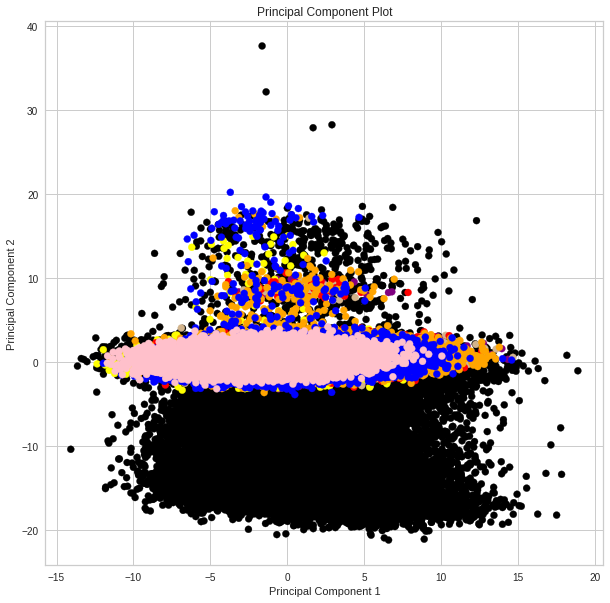

In [10]:
pii_labels = fake_pii["Labels"]
colors_map = pii_labels.map(color_dict)


plt.figure(figsize=(10,10))
PCAvisualizer = PCADecomposition(scale=True, color = colors_map, proj_dim = 2)
PCAvisualizer.fit_transform(pii_index_matrix, pii_labels)
PCAvisualizer.poof()

## Visualizing the true label trained Doc2vec model

In [11]:
pii_label_doc2vec = Doc2Vec.load("./doc2vec/doc2vec_100_true_tags.bin")

In [12]:
pii_label_matrix = get_doc2vec_matrix(texts = fake_pii['Cleaned_text'], model = pii_label_doc2vec)

100%|██████████| 800000/800000 [03:35<00:00, 3711.74it/s]


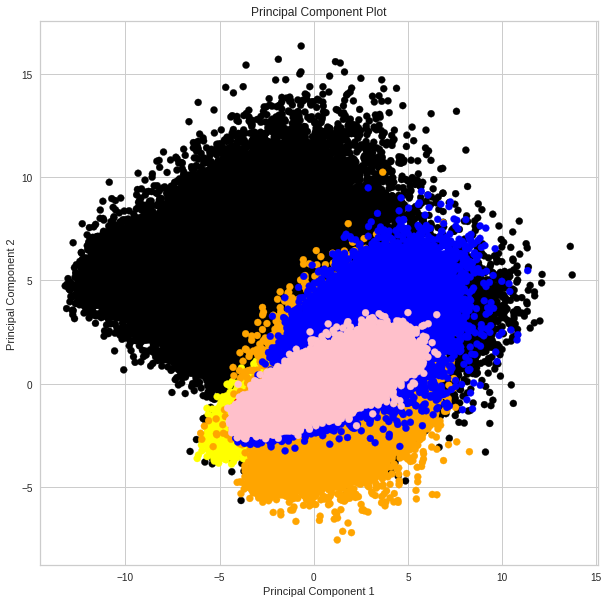

In [13]:
plt.figure(figsize=(10,10))
PCAvisualizer = PCADecomposition(scale=True, color = colors_map, proj_dim = 2)
PCAvisualizer.fit_transform(pii_label_matrix, pii_labels)
PCAvisualizer.poof()

## Training some classifiers for classifications. 

### Logistic regression for index trained Doc2vec embedding.

In [14]:
%%time
%%notify -m "model finished training"

from sklearn.linear_model import LogisticRegression
from scipy.stats import expon
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import make_pipeline

pipe = make_pipeline(LogisticRegression(random_state=0 , max_iter=10000,n_jobs = 1))

param_grid = {
    'logisticregression__C':expon(scale = 2),
    'logisticregression__penalty':['l1','l2']
}

random_cv_lr_index = RandomizedSearchCV(estimator= pipe, param_distributions = param_grid, cv =10, error_score = 0,
                               n_iter = 10 , scoring = 'f1', return_train_score=True,n_jobs = 2 )


random_cv_lr_index.fit(pii_index_matrix, fake_pii['Target'])

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


RandomizedSearchCV(cv=10, error_score=0,
          estimator=Pipeline(memory=None,
     steps=[('logisticregression', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=10000, multi_class='warn',
          n_jobs=1, penalty='l2', random_state=0, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))]),
          fit_params=None, iid='warn', n_iter=10, n_jobs=2,
          param_distributions={'logisticregression__C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fed266cffd0>, 'logisticregression__penalty': ['l1', 'l2']},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score=True, scoring='f1', verbose=0)

<IPython.core.display.Javascript object>

CPU times: user 14.1 s, sys: 983 ms, total: 15.1 s
Wall time: 15min 12s


CPU times: user 897 ms, sys: 252 ms, total: 1.15 s
Wall time: 758 ms


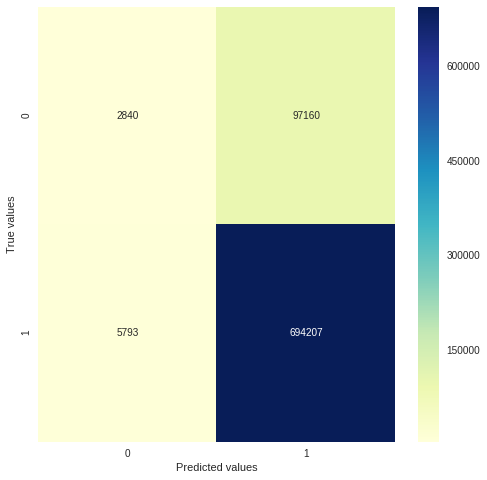

In [15]:
%%time
binary_pred = random_cv_lr_index.predict(pii_index_matrix)
binary_true = fake_pii["Target"]

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report



import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize= (8,8))
sns.heatmap(confusion_matrix(y_true = binary_true, y_pred = binary_pred), annot = True,fmt="d",cmap="YlGnBu")
plt.xlabel("Predicted values")
plt.ylabel("True values")

In [16]:
%%time
%%notify -m "metric are ready"
print(classification_report(y_true = binary_true, y_pred = binary_pred))

              precision    recall  f1-score   support

           0       0.33      0.03      0.05    100000
           1       0.88      0.99      0.93    700000

   micro avg       0.87      0.87      0.87    800000
   macro avg       0.60      0.51      0.49    800000
weighted avg       0.81      0.87      0.82    800000



<IPython.core.display.Javascript object>

CPU times: user 525 ms, sys: 31.9 ms, total: 557 ms
Wall time: 508 ms


In [17]:
random_cv_lr_index.best_estimator_

Pipeline(memory=None,
     steps=[('logisticregression', LogisticRegression(C=0.3137567181555681, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=10000,
          multi_class='warn', n_jobs=1, penalty='l2', random_state=0,
          solver='warn', tol=0.0001, verbose=0, warm_start=False))])

In [18]:
from sklearn.externals import joblib
joblib.dump(random_cv_lr_index.best_estimator_, 'doc2vec_index_100_logistic.pkl',compress = 1)

['doc2vec_index_100_logistic.pkl']

May need to change class_weight or add resampling methods. 

### Logistic regression for true label trained Doc2vec embedding.

In [19]:
%%time
%%notify -m "model finished training"

from sklearn.linear_model import LogisticRegression
from scipy.stats import expon
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import make_pipeline

pipe = make_pipeline(LogisticRegression(random_state=0 , max_iter=10000,n_jobs = 1))

param_grid = {
    'logisticregression__C':expon(scale = 2),
    'logisticregression__penalty':['l1','l2']
}

random_cv_lr_label = RandomizedSearchCV(estimator= pipe, param_distributions = param_grid, cv =10, \
                                        error_score = 0,n_iter = 10 , scoring = 'f1',\
                                        return_train_score=True,n_jobs = 2 )
                               


random_cv_lr_label.fit(pii_label_matrix, fake_pii['Target'])

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


RandomizedSearchCV(cv=10, error_score=0,
          estimator=Pipeline(memory=None,
     steps=[('logisticregression', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=10000, multi_class='warn',
          n_jobs=1, penalty='l2', random_state=0, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))]),
          fit_params=None, iid='warn', n_iter=10, n_jobs=2,
          param_distributions={'logisticregression__C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fed2602a898>, 'logisticregression__penalty': ['l1', 'l2']},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score=True, scoring='f1', verbose=0)

<IPython.core.display.Javascript object>

CPU times: user 22.4 s, sys: 941 ms, total: 23.3 s
Wall time: 23min 56s


CPU times: user 769 ms, sys: 200 ms, total: 968 ms
Wall time: 726 ms


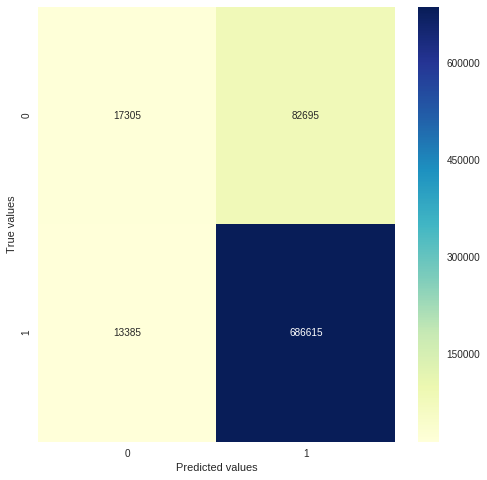

In [20]:
%%time
binary_pred = random_cv_lr_label.predict(pii_label_matrix)
binary_true = fake_pii["Target"]

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report



import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize= (8,8))
sns.heatmap(confusion_matrix(y_true = binary_true, y_pred = binary_pred), annot = True,fmt="d",cmap="YlGnBu")
plt.xlabel("Predicted values")
plt.ylabel("True values")

In [21]:
%%time
%%notify -m "metric are ready"
print(classification_report(y_true = binary_true, y_pred = binary_pred))

              precision    recall  f1-score   support

           0       0.56      0.17      0.26    100000
           1       0.89      0.98      0.93    700000

   micro avg       0.88      0.88      0.88    800000
   macro avg       0.73      0.58      0.60    800000
weighted avg       0.85      0.88      0.85    800000



<IPython.core.display.Javascript object>

CPU times: user 494 ms, sys: 40.1 ms, total: 534 ms
Wall time: 488 ms


In [22]:
random_cv_lr_label.best_estimator_

Pipeline(memory=None,
     steps=[('logisticregression', LogisticRegression(C=0.79516261259925847, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=10000,
          multi_class='warn', n_jobs=1, penalty='l2', random_state=0,
          solver='warn', tol=0.0001, verbose=0, warm_start=False))])

In [23]:
from sklearn.externals import joblib
joblib.dump(random_cv_lr_label.best_estimator_, 'doc2vec_label_100_logistic.pkl',compress = 1)

['doc2vec_label_100_logistic.pkl']

## Obviously the doc2vec model trained with true tags performs better than the one trained with just index.